# Introduction

For this project, I chose the "Bank Marketing" dataset in the UCI Machine Learning Repository(https://archive.ics.uci.edu/dataset/222/bank+marketing). This dataset contains 16 features and 45211 records. The goal of the project was to analyze the data and find a model to predict if the client will subscribe the term of deposit.




# Setup


## Install the ucimlrepo package

In [12]:
!pip install ucimlrepo
!pip install scikit-plot

## Setup Runtime Environment

In [2]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"

## Import Packages

In [3]:
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem

In [4]:
# Ignore FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Import Dataset

In [5]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

In [6]:
# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

In [7]:
X.shape

(45211, 16)

In [8]:
y.shape

(45211, 1)

In [9]:
comare_dict = {'Model':[],'Resampling':[],'Parameters':[],'Accuracy':[],'Recall':[]}
def add_compare_table(model, resampling, parameters, accuracy, recall):
    comare_dict['Model'].append(model)
    comare_dict['Resampling'].append(resampling)
    comare_dict['Parameters'].append(parameters)
    comare_dict['Accuracy'].append(accuracy)
    comare_dict['Recall'].append(recall)

# Exploratory Data Analysis

In [10]:
# variable information
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [11]:
bank_marketing.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no


In [12]:
bank_marketing.data.original

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN,no


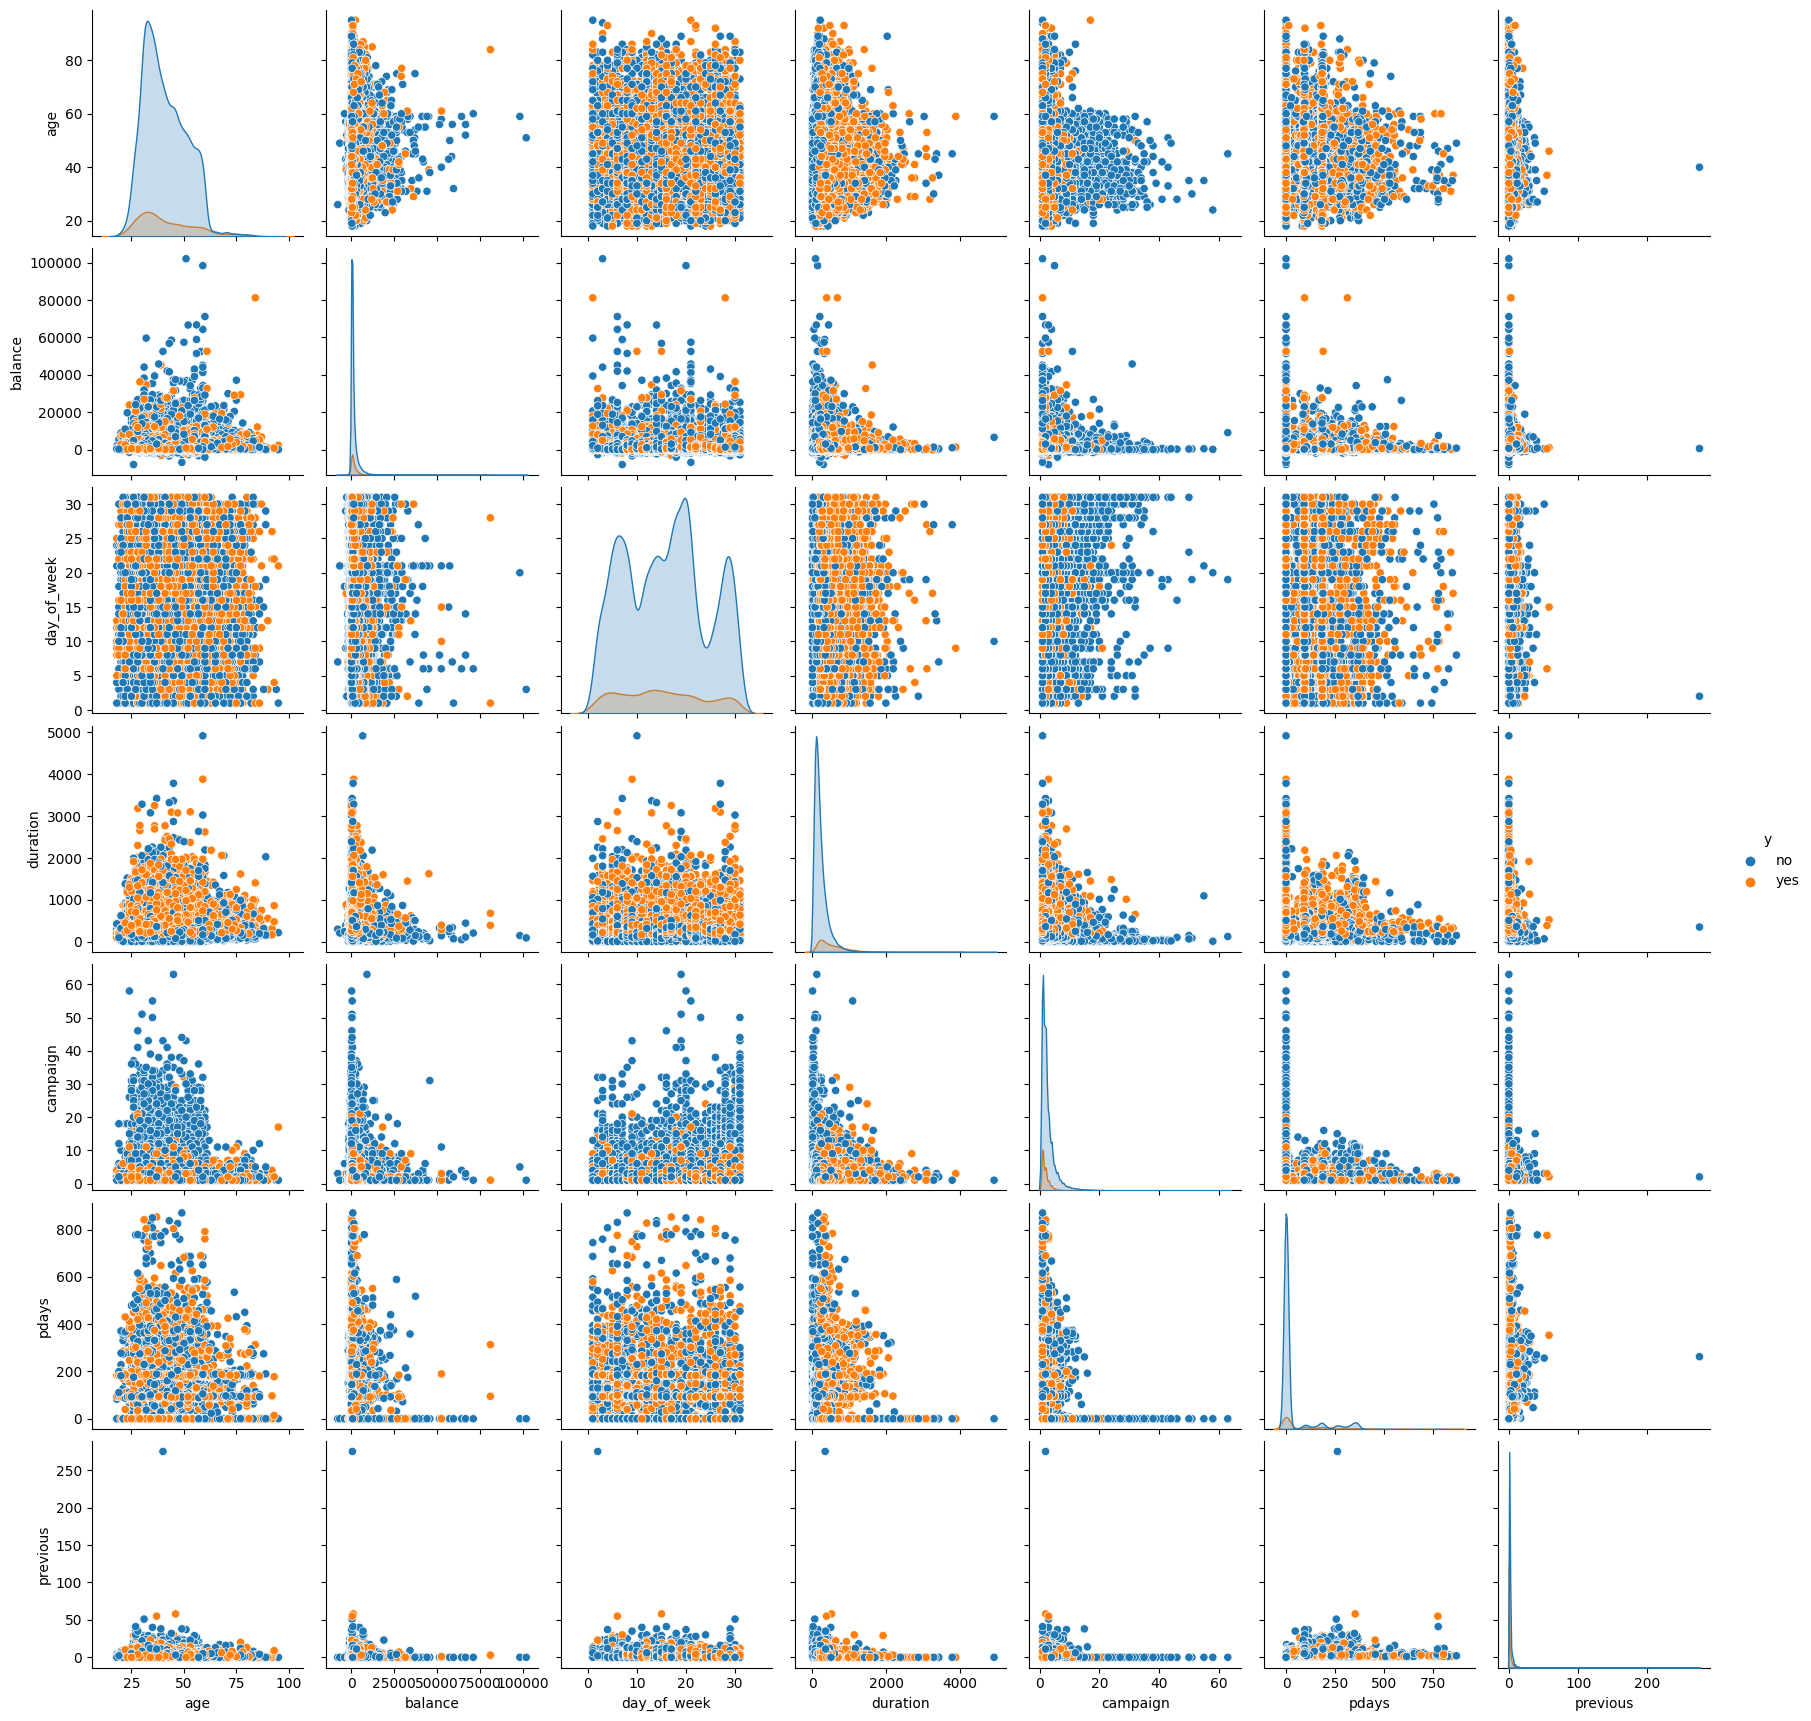

In [13]:
sns.pairplot(bank_marketing.data.original, hue="y")

<Axes: xlabel='job', ylabel='count'>

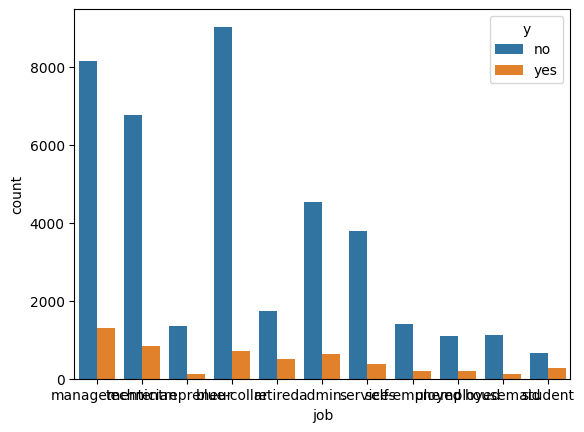

In [14]:
sns.countplot(bank_marketing.data.original, x='job', hue='y')

<Axes: xlabel='marital', ylabel='count'>

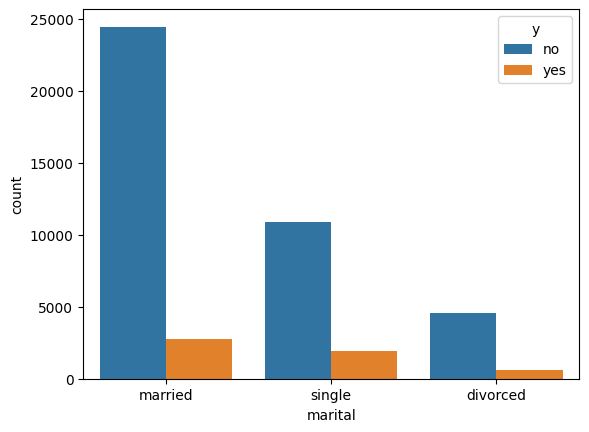

In [15]:
sns.countplot(bank_marketing.data.original, x='marital', hue='y')

<Axes: xlabel='education', ylabel='count'>

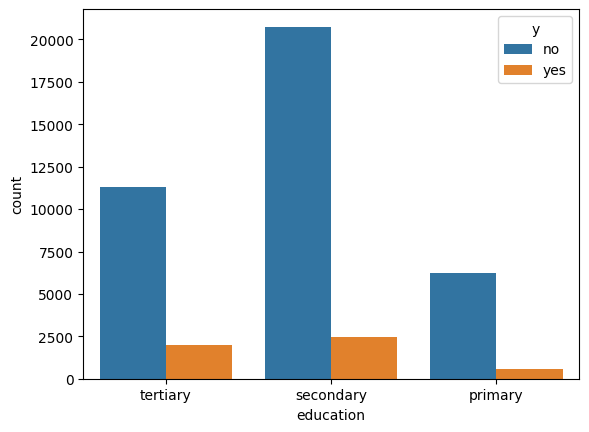

In [16]:
sns.countplot(bank_marketing.data.original, x='education', hue='y')

<Axes: xlabel='default', ylabel='count'>

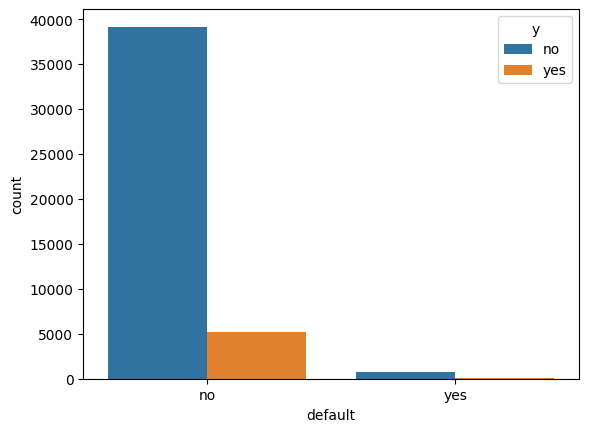

In [17]:
sns.countplot(bank_marketing.data.original, x='default', hue='y')

<Axes: xlabel='contact', ylabel='count'>

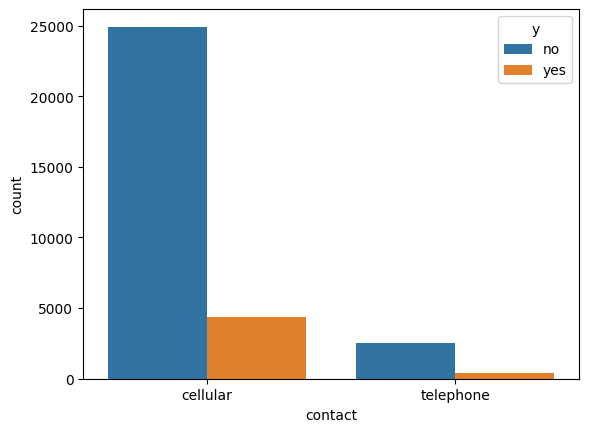

In [18]:
sns.countplot(bank_marketing.data.original, x='contact', hue='y')

<Axes: xlabel='y', ylabel='count'>

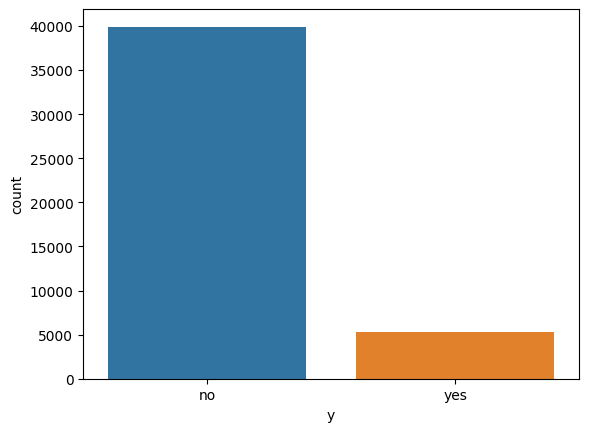

In [19]:
sns.countplot(bank_marketing.data.original, x='y')

# Clean the data

## Convert Target Varible from Binary to Integer

In [20]:
_y = np.where(y == 'yes', 1, 0)

## Check Missing Values

In [21]:
X.isna().sum(axis = 0)

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

## Factorize Categorical Features

In [22]:
job_array, job_index = X['job'].factorize()
marital_array, marital_index = X['marital'].factorize()
education_array, education_index = X['education'].factorize()
contact_array, contact_index = X['contact'].factorize()
poutcome_array, poutcome_index = X['poutcome'].factorize()

In [23]:
X.loc[:,'job'] = job_array
X.loc[:,'marital'] = marital_array
X.loc[:,'education'] = education_array
X.loc[:,'contact'] = contact_array
X.loc[:,'poutcome'] = poutcome_array

In [24]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,0,0,0,no,2143,yes,no,-1,5,may,261,1,-1,0,-1
1,44,1,1,1,no,29,yes,no,-1,5,may,151,1,-1,0,-1
2,33,2,0,1,no,2,yes,yes,-1,5,may,76,1,-1,0,-1
3,47,3,0,-1,no,1506,yes,no,-1,5,may,92,1,-1,0,-1
4,33,-1,1,-1,no,1,no,no,-1,5,may,198,1,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1,0,0,no,825,no,no,0,17,nov,977,3,-1,0,-1
45207,71,4,2,2,no,1729,no,no,0,17,nov,456,2,-1,0,-1
45208,72,4,0,1,no,5715,no,no,0,17,nov,1127,5,184,3,2
45209,57,3,0,1,no,668,no,no,1,17,nov,508,4,-1,0,-1


## Convert Binary Features to Integer

In [25]:
X.loc[:,'default'] = np.where(X['default'] == 'yes', 1, 0)
X.loc[:,'housing'] = np.where(X['housing'] == 'yes', 1, 0)
X.loc[:,'loan'] = np.where(X['loan'] == 'yes', 1, 0)

In [26]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,0,0,0,0,2143,1,0,-1,5,may,261,1,-1,0,-1
1,44,1,1,1,0,29,1,0,-1,5,may,151,1,-1,0,-1
2,33,2,0,1,0,2,1,1,-1,5,may,76,1,-1,0,-1
3,47,3,0,-1,0,1506,1,0,-1,5,may,92,1,-1,0,-1
4,33,-1,1,-1,0,1,0,0,-1,5,may,198,1,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1,0,0,0,825,0,0,0,17,nov,977,3,-1,0,-1
45207,71,4,2,2,0,1729,0,0,0,17,nov,456,2,-1,0,-1
45208,72,4,0,1,0,5715,0,0,0,17,nov,1127,5,184,3,2
45209,57,3,0,1,0,668,0,0,1,17,nov,508,4,-1,0,-1


## Convert Feature Month to Integer

In [27]:
X['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [28]:
X.loc[:,'month'] = pd.to_datetime(X['month'], format='%b').dt.month

In [29]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,0,0,0,0,2143,1,0,-1,5,5,261,1,-1,0,-1
1,44,1,1,1,0,29,1,0,-1,5,5,151,1,-1,0,-1
2,33,2,0,1,0,2,1,1,-1,5,5,76,1,-1,0,-1
3,47,3,0,-1,0,1506,1,0,-1,5,5,92,1,-1,0,-1
4,33,-1,1,-1,0,1,0,0,-1,5,5,198,1,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1,0,0,0,825,0,0,0,17,11,977,3,-1,0,-1
45207,71,4,2,2,0,1729,0,0,0,17,11,456,2,-1,0,-1
45208,72,4,0,1,0,5715,0,0,0,17,11,1127,5,184,3,2
45209,57,3,0,1,0,668,0,0,1,17,11,508,4,-1,0,-1


## Check Duplicated Data

In [30]:
X.duplicated().sum()

0

# Linear Regression Model

## Prepare Train/Test Set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, _y.ravel(), test_size=0.25, random_state=16)

## Build the Model

In [32]:
logreg = LogisticRegression(solver = 'liblinear', random_state=16, max_iter=1000)

## Train the Model

In [33]:
# fit the model with data
logreg.fit(X_train, y_train)

y_pred_0 = logreg.predict(X_test)

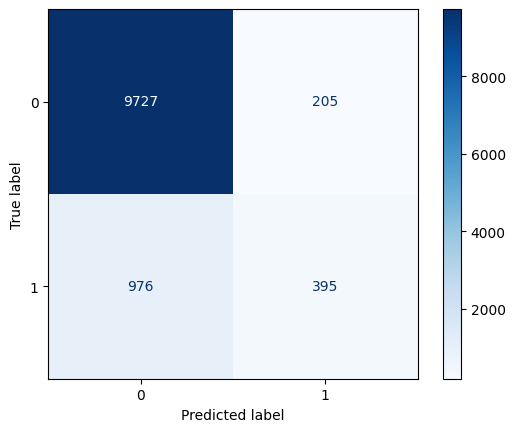

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_0, cmap=plt.cm.Blues)

In [35]:
accuracy_score(y_test, y_pred_0)

0.8955144651862338

In [36]:
recall_score(y_test, y_pred_0)

0.28811086797957697

In [37]:
add_compare_table('LogisticRegression', 'N/A', 'solver = "liblinear", random_state=16, max_iter=1000', accuracy_score(y_test, y_pred_0), recall_score(y_test, y_pred_0))

## Plot the ROC Curve

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

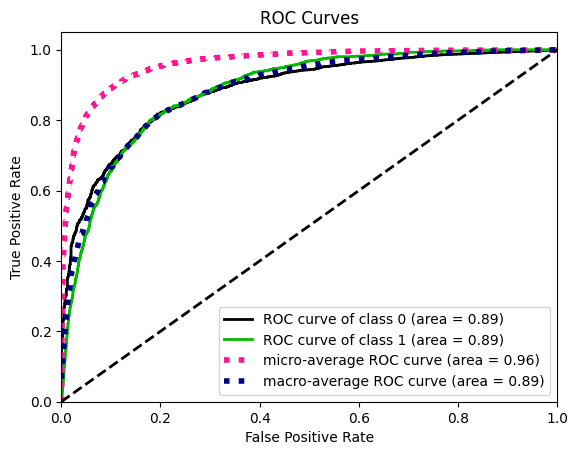

In [38]:
# Predict probabilities for the testing data
skplt.metrics.plot_roc(y_test, logreg.predict_proba(X_test))

## Handle Imbalanced Data

https://semaphoreci.com/blog/imbalanced-data-machine-learning-python


In [39]:
y_test.sum()/len(y_test)

0.12129523135450765

## OverSampling

<Axes: xlabel='y', ylabel='count'>

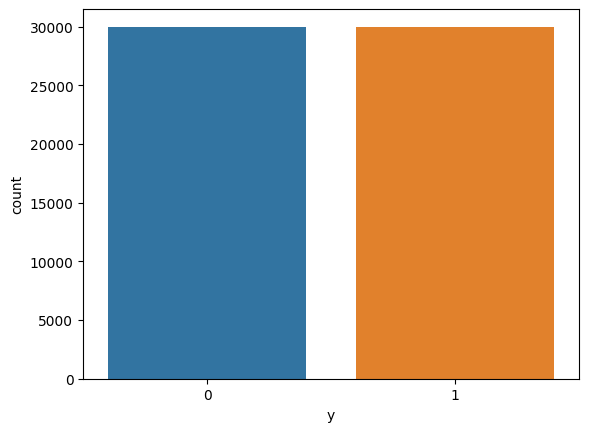

In [40]:
# Apply oversampling using RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

sns.countplot(pd.DataFrame({'y': y_train_oversampled}), x='y')

In [41]:
logreg_over = LogisticRegression(solver = 'liblinear', random_state=16, max_iter=1000)

# fit the model with data
logreg_over.fit(X_train_oversampled, y_train_oversampled)
y_test_pred_oversampled = logreg_over.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred_oversampled))
print("Recall  :", recall_score(y_test, y_test_pred_oversampled))

Accuracy: 0.8205786074493497
Recall  : 0.7899343544857768


In [42]:
add_compare_table('LogisticRegression', 'Oversampling', 'solver = "liblinear", random_state=16, max_iter=1000', accuracy_score(y_test, y_test_pred_oversampled), recall_score(y_test, y_test_pred_oversampled))

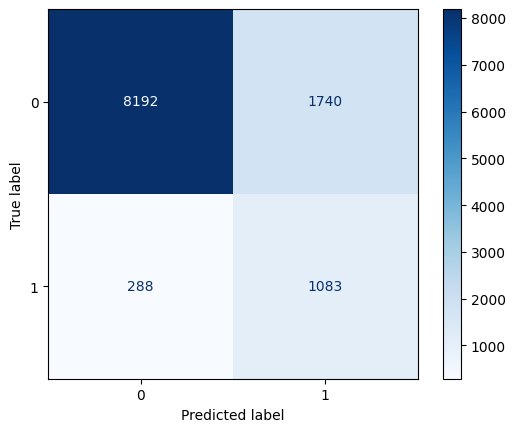

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_oversampled, cmap=plt.cm.Blues)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

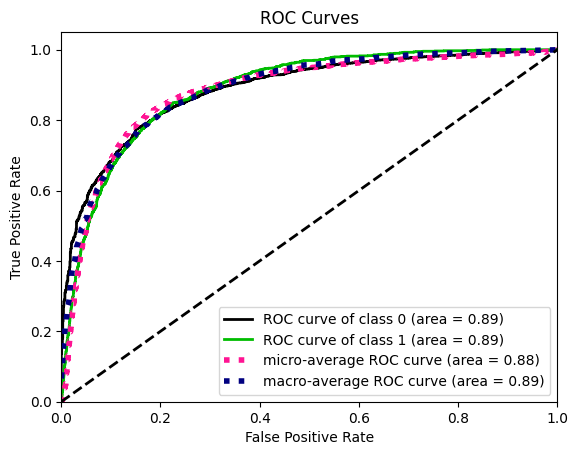

In [44]:
skplt.metrics.plot_roc(y_test, logreg_over.predict_proba(X_test))

## Undersampling

<Axes: xlabel='y', ylabel='count'>

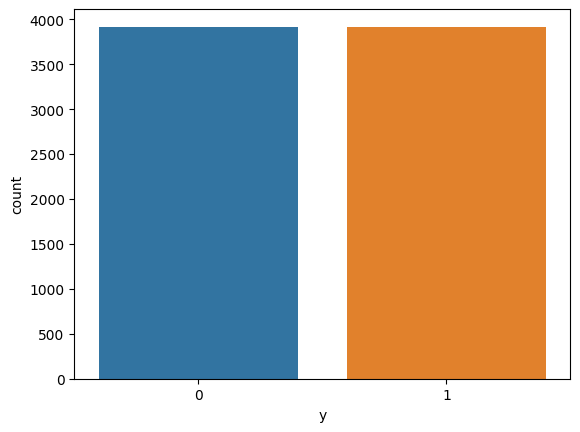

In [45]:
# Apply undersampling using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

sns.countplot(pd.DataFrame({'y': y_train_undersampled}), x='y')

In [46]:
logreg_under = LogisticRegression(solver = 'liblinear', random_state=16, max_iter=1000)

# fit the model with data
logreg_under.fit(X_train_undersampled, y_train_undersampled)
y_test_pred_undersampled = logreg_under.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred_undersampled))
print("Recall  :", recall_score(y_test, y_test_pred_undersampled))

Accuracy: 0.8202247191011236
Recall  : 0.7833698030634574


In [47]:
add_compare_table('LogisticRegression', 'Undersampling', 'solver = "liblinear", random_state=16, max_iter=1000', accuracy_score(y_test, y_test_pred_undersampled), recall_score(y_test, y_test_pred_undersampled))

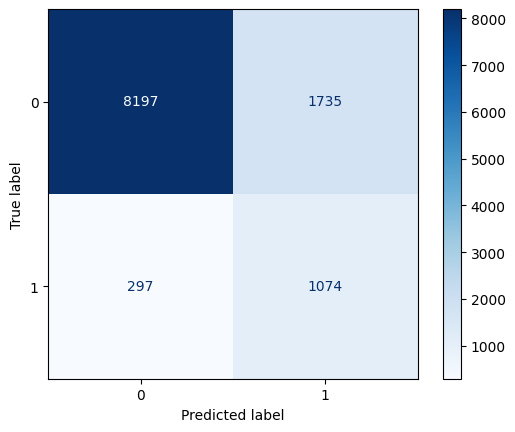

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_undersampled, cmap=plt.cm.Blues)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

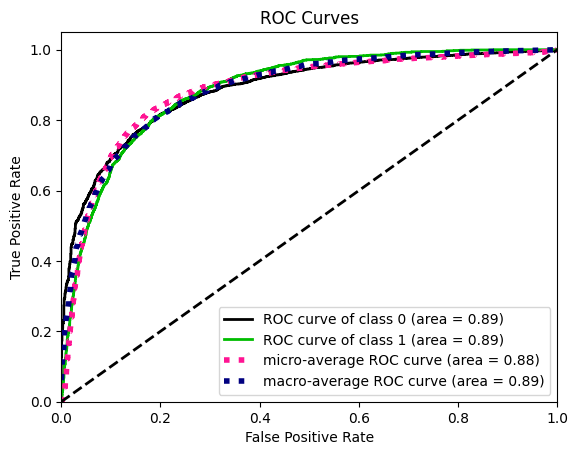

In [49]:
skplt.metrics.plot_roc(y_test, logreg_under.predict_proba(X_test))

# Non-Parametric Models, Ensemble Methods and Kernel Methods

## Build Models

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC


In [50]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
]

classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(C=0.025, random_state=42, tol=1e-5, max_iter=5000),
    SVC(gamma=2, C=1, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, max_features=10, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
]

## Train Models

In [51]:
%%time
models = []
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), Nystroem(gamma=.2, random_state=1), clf)
    clf.fit(X_train_undersampled, y_train_undersampled)
    y_pred = clf.predict(X_test)
    print('{:<18s}: accuracy={:.10f}, recall={:.10f}'.format(name, accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)))
    models.append(clf)
    add_compare_table(name, 'Undersampling', clf.get_params(False), accuracy_score(y_test, y_pred), recall_score(y_test, y_pred))

Nearest Neighbors : accuracy=0.7697071574, recall=0.7636761488
Linear SVM        : accuracy=0.6933557463, recall=0.8563092633
RBF SVM           : accuracy=0.7349376272, recall=0.8621444201
Decision Tree     : accuracy=0.7925329559, recall=0.6805251641
Random Forest     : accuracy=0.7590020349, recall=0.8264040846
AdaBoost          : accuracy=0.8040343272, recall=0.7534646244
CPU times: user 23.8 s, sys: 3.38 s, total: 27.2 s
Wall time: 20.9 s


## Compare Models

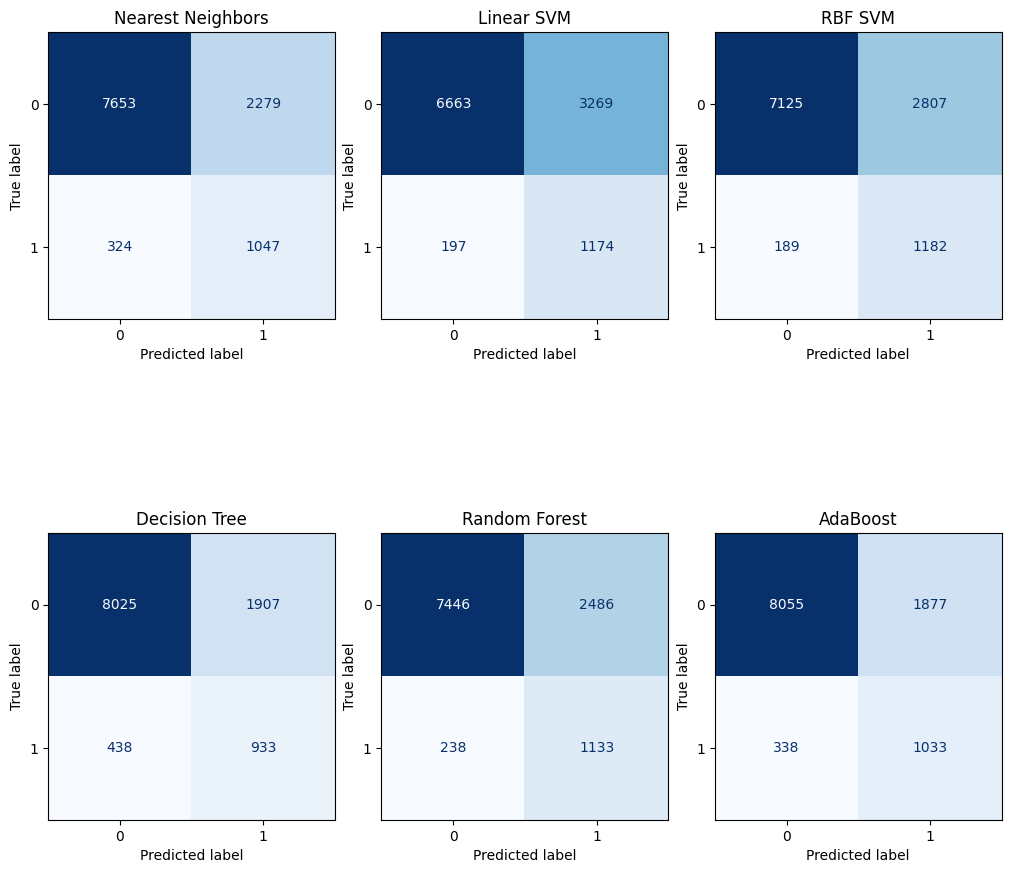

In [52]:
_, axs = plt.subplots(2, 3, figsize=(10, 10), layout="constrained")

i = 0
axs_array = axs.flat
for name, clf in zip(names, models):
    y_pred = clf.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, ax=axs_array[i], colorbar=False)
    disp.ax_.set_title(name)
    i += 1

plt.show()

# Hyperparameter Optimization for SVC

In [53]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[("scaler", StandardScaler()), ("nystroem", Nystroem(gamma=.2, random_state=1)), ("svc", SVC(random_state=42))])

parameters = {
    'svc__C': [0.1, 1, 10, 50],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10]
}

svc = GridSearchCV(pipe, parameters, cv=3, scoring='recall', verbose=5)
svc.fit(X_train_undersampled, y_train_undersampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END ......svc__C=0.1, svc__gamma=0.001;, score=0.991 total time=   3.7s
[CV 2/3] END ......svc__C=0.1, svc__gamma=0.001;, score=0.995 total time=   3.7s
[CV 3/3] END ......svc__C=0.1, svc__gamma=0.001;, score=0.970 total time=   3.7s
[CV 1/3] END .......svc__C=0.1, svc__gamma=0.01;, score=0.991 total time=   3.7s
[CV 2/3] END .......svc__C=0.1, svc__gamma=0.01;, score=0.995 total time=   3.7s
[CV 3/3] END .......svc__C=0.1, svc__gamma=0.01;, score=0.970 total time=   3.7s
[CV 1/3] END ........svc__C=0.1, svc__gamma=0.1;, score=0.953 total time=   3.5s
[CV 2/3] END ........svc__C=0.1, svc__gamma=0.1;, score=0.970 total time=   3.5s
[CV 3/3] END ........svc__C=0.1, svc__gamma=0.1;, score=0.949 total time=   3.6s
[CV 1/3] END ..........svc__C=0.1, svc__gamma=1;, score=0.880 total time=   2.9s
[CV 2/3] END ..........svc__C=0.1, svc__gamma=1;, score=0.871 total time=   2.9s
[CV 3/3] END ..........svc__C=0.1, svc__gamma=1;

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nystroem',
                                        Nystroem(gamma=0.2, random_state=1)),
                                       ('svc', SVC(random_state=42))]),
             param_grid={'svc__C': [0.1, 1, 10, 50],
                         'svc__gamma': [0.001, 0.01, 0.1, 1, 10]},
             scoring='recall', verbose=5)

In [54]:
svc_predict = svc.best_estimator_.predict(X_test)
print("Best parameter:", svc.best_params_)
print("Accuracy:", accuracy_score(y_test, svc_predict))
print("Recall  :", recall_score(y_test, svc_predict))

Best parameter: {'svc__C': 0.1, 'svc__gamma': 0.001}
Accuracy: 0.2689551446518623
Recall  : 0.9803063457330415


In [55]:
add_compare_table('RBF SVC', 'Undersampling', svc.best_params_, accuracy_score(y_test, svc_predict), recall_score(y_test, svc_predict))

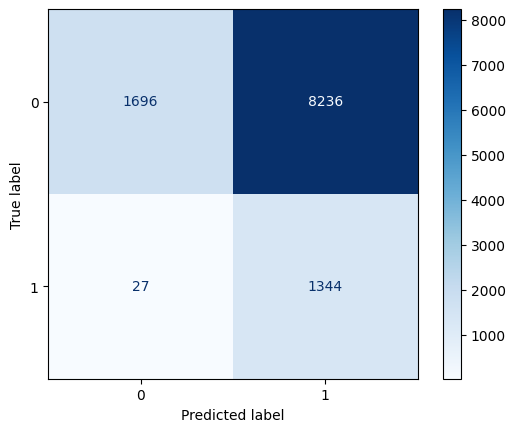

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, svc_predict, cmap=plt.cm.Blues)

# Summary





## Compare Models

In [57]:
from IPython.display import display, HTML

display(HTML(pd.DataFrame(comare_dict).to_html()))

,Model,Resampling,Parameters,Accuracy,Recall
0,LogisticRegression,N/A,"solver = ""liblinear"", random_state=16, max_iter=1000",0.895514,0.288111
1,LogisticRegression,Oversampling,"solver = ""liblinear"", random_state=16, max_iter=1000",0.820579,0.789934
2,LogisticRegression,Undersampling,"solver = ""liblinear"", random_state=16, max_iter=1000",0.820225,0.783370
3,Nearest Neighbors,Undersampling,"{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('nystroem', Nystroem(gamma=0.2, random_state=1)), ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))], 'verbose': False}",0.769707,0.763676
4,Linear SVM,Undersampling,"{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('nystroem', Nystroem(gamma=0.2, random_state=1)), ('linearsvc', LinearSVC(C=0.025, max_iter=5000, random_state=42, tol=1e-05))], 'verbose': False}",0.693356,0.856309
5,RBF SVM,Undersampling,"{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('nystroem', Nystroem(gamma=0.2, random_state=1)), ('svc', SVC(C=1, gamma=2, random_state=42))], 'verbose': False}",0.734938,0.862144
6,Decision Tree,Undersampling,"{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('nystroem', Nystroem(gamma=0.2, random_state=1)), ('decisiontreeclassifier', DecisionTreeClassifier(max_depth=5, random_state=42))], 'verbose': False}",0.792533,0.680525
7,Random Forest,Undersampling,"{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('nystroem', Nystroem(gamma=0.2, random_state=1)), ('randomforestclassifier', RandomForestClassifier(max_depth=5, max_features=10, random_state=42))], 'verbose': False}",0.759002,0.826404
8,AdaBoost,Undersampling,"{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('nystroem', Nystroem(gamma=0.2, random_state=1)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME', random_state=42))], 'verbose': False}",0.804034,0.753465
9,RBF SVC,Undersampling,"{'svc__C': 0.1, 'svc__gamma': 0.001}",0.268955,0.980306


## Discussion

*   The Linear LogisticRegression model works fine. It's quick and simple.
*   The dataset is very imbalanced. Sometimes it could be a problem. In our dataset, we found that only 29% of true cases are successfully predicted by the model. That would be a problem because that means we might miss 71% of potential clients.
*   We use resampling techniques to solve this issue. Both oversampling and undersampling can successfully improve the true positive rate from 29% to 78-79%.
*   Non-linear models have better performance compare to linear regression model. In our case, **SVC with rbf kernel** has the best recall score. Notice that Linear SVC also work well.
*   However, training SVC model is very time-consuming if the dataset is too large, so we must use undersampling data to train it. If we use oversampling data set, it will take too long to finish the training, and sometimes it will cause timeout issue when you run in Google Colab or Kaggle.
*  Finally, we use GridSearchCV to tune the hyperparameters. We use SVC with rbf kernel as the base estimator. After iterating all possible combinations, we get a best combination and successfully further improve the recall to 98%. Notice that when we focuse on improving the recall score, other metrics like accuracy or precision will get worse at the same time. That's a trade off in the real world case. We can't ask for a model perfectly doing everything.